In [30]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats import gengamma, laplace, norm
from scipy.stats import kstwobign, kstest, ks_1samp, anderson, anderson_ksamp, cramervonmises, kstwo, ksone
from scipy.special import kolmogorov
import matplotlib.pyplot as plt
from utilities import *
from plot_utilities import *
%matplotlib inline
import pickle

np.random.seed(42)

In [31]:
data_dict = pd.read_pickle('../data/Toy_Data_Dict_Normalized.pickle')
def rename_cols(df):
    return df.replace({'Orientation' : {'Horizontal detail' : 'H', 'Vertical detail' : 'V', 'Diagonal detail' : 'D'}})

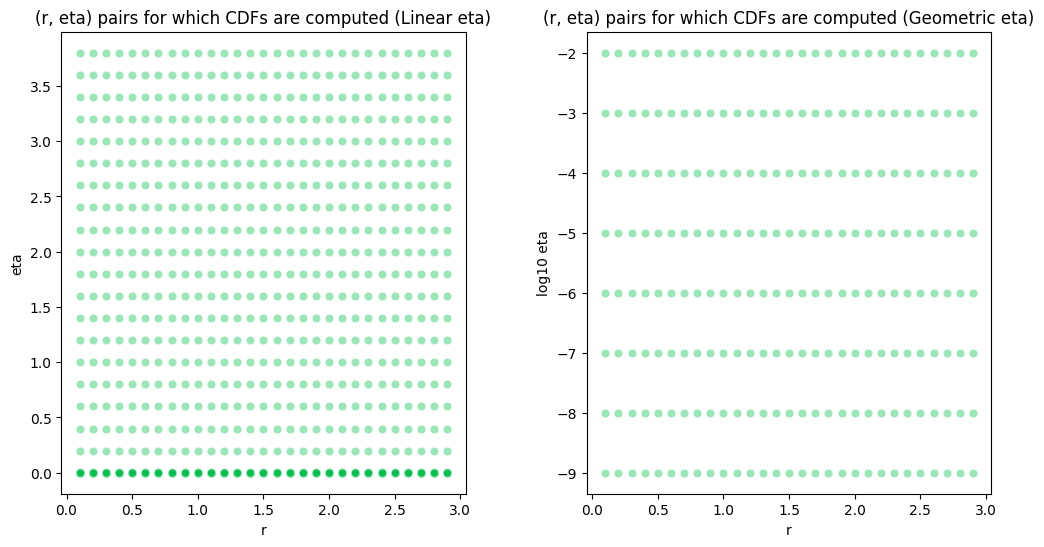

In [34]:
with open('pickles/updated_100000.pickle', 'rb') as handle:
    all_cdfs = pickle.load(handle)
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : all_cdfs.items()})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1 (Linear eta)
sns.scatterplot(x=all_cdfs_df['r'], y=all_cdfs_df['eta'], color='xkcd:shamrock green', alpha=0.4, ax=ax1)
ax1.set_xlabel('r')
ax1.set_ylabel('eta')
ax1.set_title('(r, eta) pairs for which CDFs are computed (Linear eta)')

# Plot 2 (Geometric eta)
mask = all_cdfs_df['eta'].isin(10**np.arange(-9.0, 0))
sns.scatterplot(x=all_cdfs_df['r'], y=np.log10(all_cdfs_df[mask]['eta']), color='xkcd:shamrock green', alpha=0.4, ax=ax2)
ax2.set_xlabel('r')
ax2.set_ylabel(f'log10 eta')
ax2.set_title('(r, eta) pairs for which CDFs are computed (Geometric eta)')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [35]:
# Experimental cell to play around with different layers
layer = 4
xs = np.linspace(-100, 100, 10000)
obs_x, df = make_layer_df(data_dict, layer, all_cdfs_df)
total_samples = obs_x.size
r_prime, eta_prime, kstest_stat, kstest_pval = find_best_metric(obs_x, all_cdfs_df)
print(f"Best parameters {(r_prime, eta_prime)} with KS-test Statistic {np.round(kstest_stat, 4)} and pvalue {kstest_pval}, layer {layer} with num_samples={total_samples}")
distance, location = visualize_cdfs(obs_x, r_prime, eta_prime, all_cdfs)
create_scatter_plots(df, 'kstest_stat', 'kstest_pval')
df.head()

TypeError: make_layer_df() missing 1 required positional argument: 'all_cdfs_df'

In [ ]:
# %%time
# all_num_samples = np.sort(np.append(5*10**np.arange(2.0, np.ceil(np.log10(total_samples))), 10**np.arange(3.0, np.ceil(np.log10(total_samples)))))
# np.random.seed(42)
# x = obs_x[np.random.permutation(total_samples)]
# val_df = pd.concat([val_df_fixed_num(x, n, all_cdfs_df) for n in all_num_samples])
# val_df.to_csv(f'pickles/val_df{layer}.csv')
# val_df.value_counts(['r', 'eta'])

r    eta   
2.9  0.0000    894
2.8  0.0000      4
2.5  0.0010      1
2.6  0.0010      1
2.7  0.0100      1
2.8  0.0001      1
2.9  0.0010      1
Name: count, dtype: int64


KeyboardInterrupt: 

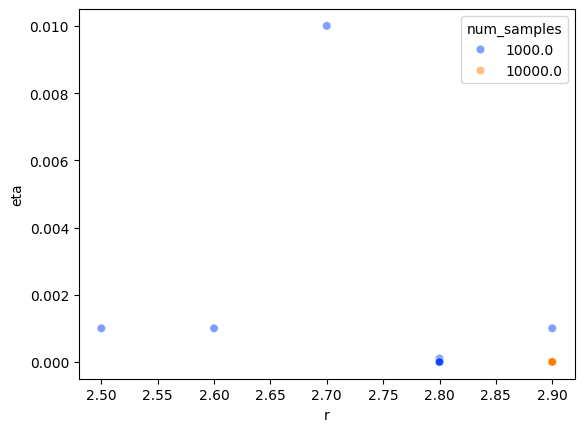

In [28]:
np.random.seed(42)
x = obs_x[np.random.permutation(total_samples)]
val_df = pd.read_csv(f'pickles/val_df{layer}.csv', index_col='Unnamed: 0')
print(val_df.value_counts(['r', 'eta']))

sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.5)
r, eta, _, _ = find_best_metric(x, df=all_cdfs_df)
plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
plt.title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
print(r, eta)
plt.legend()

2.9 0.0


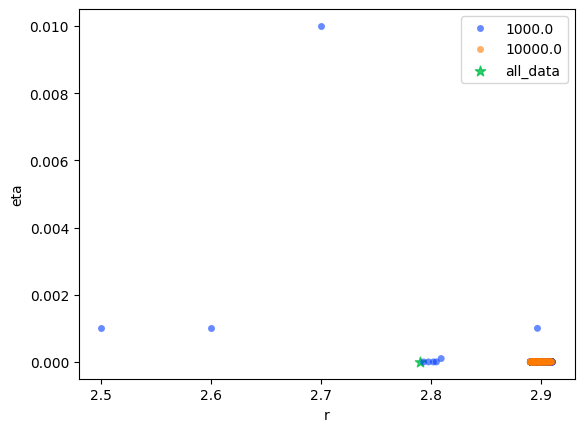

In [36]:
np.random.seed(42)
# if a lot of points, consider changing from scatterplot to stripplot
sns.stripplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.6)
r, eta, _, _ = find_best_metric(x, df=all_cdfs_df)
plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.8)
print(r, eta)
plt.legend()

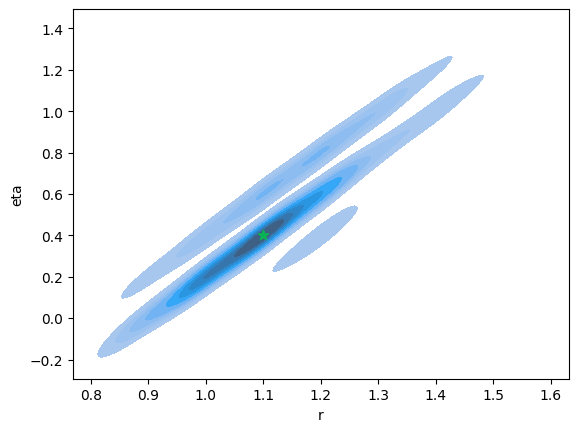

In [380]:
mask = val_df['num_samples'] == 100
sns.kdeplot(val_df.drop(['kstest_pval'], axis = 1)[mask], x = 'r', y = 'eta', fill=True)
plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.8)

In [9]:
val_df7 = pd.read_csv('pickles/val_df7.csv')

<Axes: xlabel='r', ylabel='eta'>

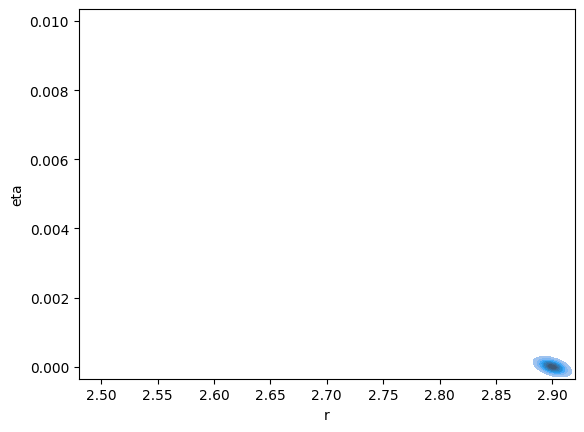

In [11]:
sns.kdeplot(val_df7.drop(['kstest_pval'], axis = 1)[val_df7['num_samples'] == 1000], x = 'r', y = 'eta', fill=True)
#plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.8)

In [16]:
best_params_df = pd.DataFrame(columns = ['layer', 'num_samples', 'r', 'eta', 'kstest_stat', 'kstest_pval'])
for i, layer in enumerate(np.arange(2, 9)):
    obs_x, df = make_layer_df(data_dict, layer, all_cdfs_df)
    n = obs_x.size
    result = find_best_metric(obs_x, all_cdfs_df)
    best_params_df.loc[i, :] = np.append(np.array([layer, n]), result)
best_params_df

Number of samples: 802
Number of samples: 3208
Number of samples: 12832
Number of samples: 51328
Number of samples: 205312
Number of samples: 821248
Number of samples: 3284992


,layer,num_samples,r,eta,kstest_stat,kstest_pval
0,2.0,802.0,0.6,3.0,0.046566,0.059799
1,3.0,3208.0,0.7,3.6,0.02462,0.040255
2,4.0,12832.0,0.8,3.2,0.013868,0.014238
3,5.0,51328.0,0.9,1.6,0.00432,0.292771
4,6.0,205312.0,1.1,0.4,0.007799,0.0
5,7.0,821248.0,2.9,0.0,0.037188,0.0
6,8.0,3284992.0,2.9,0.0,0.178956,0.0


In [1]:
best_params_df

NameError: name 'best_params_df' is not defined

In [17]:
best_params_diag_df = pd.DataFrame(columns = ['layer', 'num_samples', 'r', 'eta', 'kstest_stat', 'kstest_pval'])
for i, layer in enumerate(np.arange(2, 9)):
    obs_x, df = make_layer_df(data_dict, layer, all_cdfs_df, only_diag=True)
    n = obs_x.size
    result = find_best_metric(obs_x, all_cdfs_df)
    best_params_diag_df.loc[i, :] = np.append(np.array([layer, n]), result)
best_params_diag_df

Number of samples: 802
Number of samples: 3208
Number of samples: 12832
Number of samples: 51328
Number of samples: 205312
Number of samples: 821248
Number of samples: 3284992


,layer,num_samples,r,eta,kstest_stat,kstest_pval
0,2.0,802.0,0.6,3.0,0.046566,0.059799
1,3.0,3208.0,0.7,3.6,0.02462,0.040255
2,4.0,12832.0,0.8,3.2,0.013868,0.014238
3,5.0,51328.0,0.9,1.6,0.00432,0.292771
4,6.0,205312.0,1.1,0.4,0.007799,0.0
5,7.0,821248.0,2.9,0.0,0.037188,0.0
6,8.0,3284992.0,2.9,0.0,0.178956,0.0


<Axes: xlabel='eta', ylabel='r'>

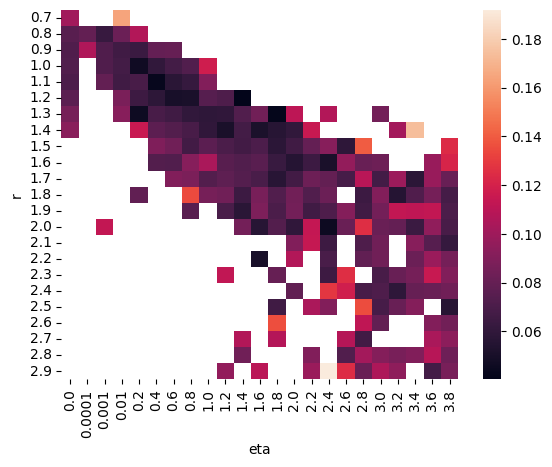

In [344]:
sns.heatmap(val_df.drop(['kstest_pval', 'num_samples'], axis = 1).pivot_table(index = 'r', columns = 'eta', values = 'kstest_stat'))

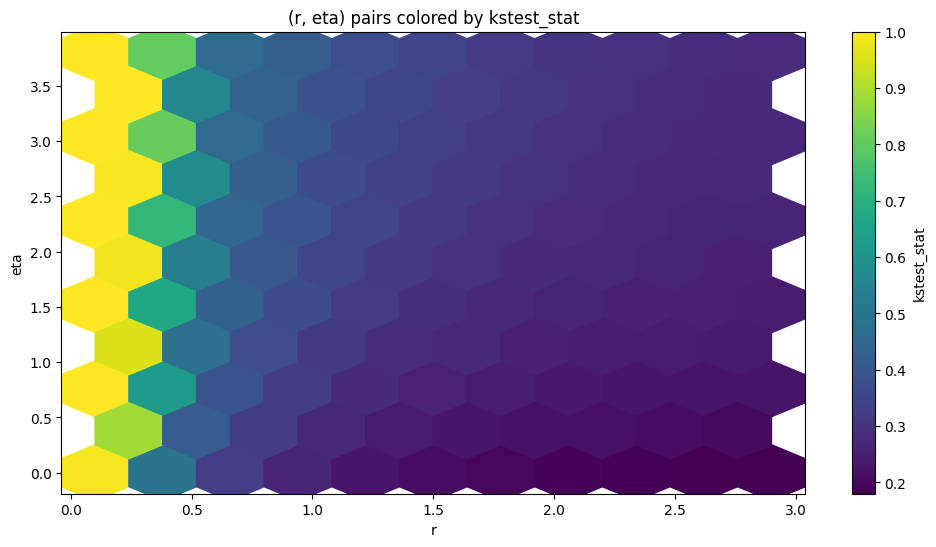

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot 1 (Linear eta)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
metric = 'kstest_stat'

# Create the hexbin plot
hexbin = ax.hexbin(df['r'], df['eta'], C=df[metric], gridsize=10, cmap='viridis')

# Add colorbar and label
cbar = fig.colorbar(hexbin, ax=ax)
cbar.set_label(metric)

# Set title and axis labels
ax.set_xlabel('r')
ax.set_ylabel('eta')
ax.set_title(f'(r, eta) pairs colored by {metric}')

plt.show()

ValueError: Contour levels must be increasing

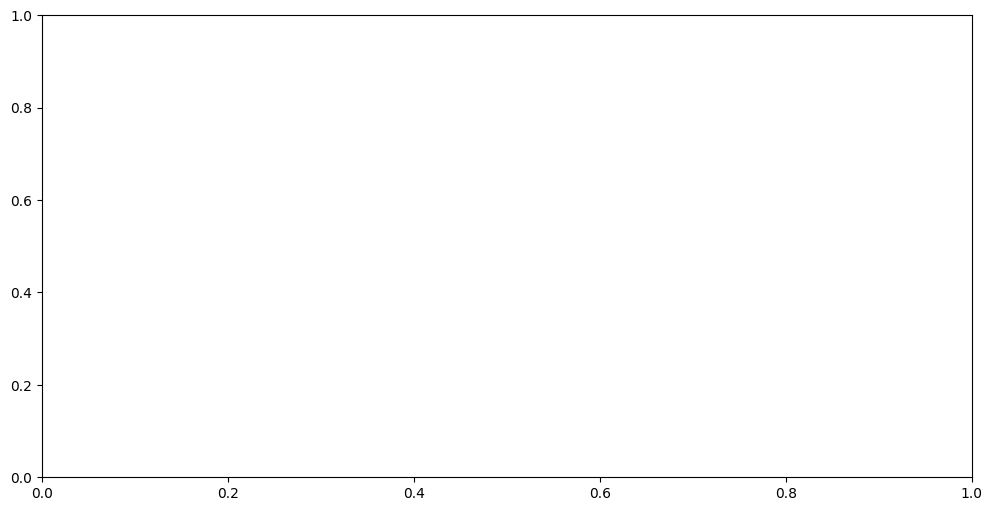

In [25]:
# Plot 1 (Linear eta)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
metric = 'kstest_stat'
scatter1 = plt.contourf(df['r'], df['eta'], df[metric], cmap='viridis', alpha=0.8)
ax1.set_xlabel('r')
ax1.set_ylabel('eta')
ax1.set_title('(r, eta) pairs colored by {}'.format(metric))

cbar1 = fig.colorbar(scatter1, ax=ax1)
cbar1.set_label(metric)
plt.show()

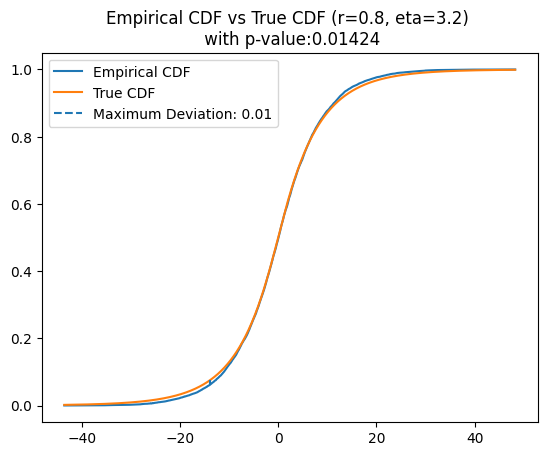

In [ ]:
distance, location = visualize_cdfs(obs_x, 0.8, 3.2, all_cdfs)

In [ ]:
def create_scatter_plots(df, metric):
    """
    Create two scatter plots side by side, where the color of each point represents the value from the specified metric column.
    
    Arguments:
    df -- A pandas DataFrame containing the columns 'r', 'eta', and the specified metric column.
    metric -- The name of the column in the DataFrame to use for color mapping.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot 1 (Linear eta)
    scatter1 = ax1.scatter(df['r'], df['eta'], c=df[metric], cmap='viridis', alpha=0.8)
    ax1.set_xlabel('r')
    ax1.set_ylabel('eta')
    ax1.set_title('(r, eta) pairs colored by {}'.format(metric))

    cbar1 = fig.colorbar(scatter1, ax=ax1)
    cbar1.set_label(metric)
    
    # Plot 2 (Geometric eta)
    mask = df['eta'].isin(10**np.arange(-9.0, 0))
    scatter2 = ax2.scatter(df[mask]['r'], np.log10(df[mask]['eta']), c=df[mask][metric], cmap='viridis', alpha=0.8)
    ax2.set_xlabel('r')
    ax2.set_ylabel('eta')
    ax2.set_title('(r, eta) pairs colored by {} (Geometric eta)'.format(metric))

    cbar2 = fig.colorbar(scatter2, ax=ax2)
    cbar2.set_label(metric)

    plt.subplots_adjust(wspace=0.3)
    plt.show()

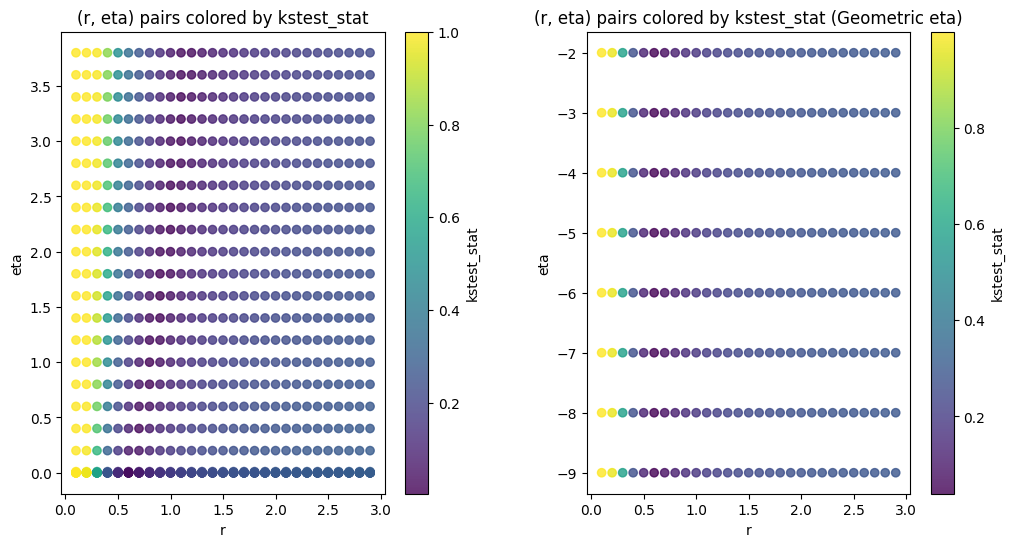

In [ ]:
create_scatter_plots(df, 'kstest_stat')

In [ ]:
def create_contour_plot(df, metric):
    """Create a contour plot with labeled level sets, where the color represents the values from the specified metric column.
    Arguments:
    df -- A pandas DataFrame containing the columns 'r', 'eta', and the specified metric column.
    metric -- The name of the column in the DataFrame to use for color mapping.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot 1 (Linear eta)
    r_meshgrid, eta_meshgrid = np.meshgrid(df['r'].unique(), df['eta'].unique())
    metric_meshgrid = np.zeros_like(r_meshgrid)
    for i, r in enumerate(df['r'].unique()):
        for j, eta in enumerate(df['eta'].unique()):
            mask = (df['r'] == r) & (df['eta'] == eta)
            if mask.any():
                metric_meshgrid[j, i] = df[mask][metric].values[0]

    # Determine the min and max values of the metric for setting contour levels
    metric_min = metric_meshgrid.min()
    metric_max = metric_meshgrid.max()

    # Create 20 contour levels between the min and max values
    levels = np.linspace(0, 1, 11)

    contour1 = ax1.contourf(r_meshgrid, eta_meshgrid, metric_meshgrid, levels=levels, cmap='viridis')
    contour_lines1 = ax1.contour(r_meshgrid, eta_meshgrid, metric_meshgrid, levels=levels, colors='k')
    ax1.clabel(contour_lines1, inline=True, fontsize=8)
    ax1.set_xlabel('r')
    ax1.set_ylabel('eta')
    ax1.set_title('(r, eta) pairs colored by {}'.format(metric))
    cbar1 = fig.colorbar(contour1, ax=ax1)
    cbar1.set_label(metric)

    # Plot 2 (Geometric eta)
    mask = df['eta'].isin(10**np.arange(-9.0, 0))
    r_meshgrid, eta_meshgrid = np.meshgrid(df[mask]['r'].unique(), np.log10(df[mask]['eta'].unique()))
    metric_meshgrid = np.zeros_like(r_meshgrid)
    for i, r in enumerate(df[mask]['r'].unique()):
        for j, eta in enumerate(np.log10(df[mask]['eta'].unique())):
            mask2 = (df[mask]['r'] == r) & (df[mask]['eta'] == 10**eta)
            if mask2.any():
                metric_meshgrid[j, i] = df[mask & mask2][metric].iloc[0]
    contour2 = ax2.contourf(r_meshgrid, eta_meshgrid, metric_meshgrid, cmap='viridis')
    contour_lines2 = ax2.contour(r_meshgrid, eta_meshgrid, metric_meshgrid, levels=contour2.levels, colors='k')
    ax2.clabel(contour_lines2, inline=True, fontsize=8)
    ax2.set_xlabel('r')
    ax2.set_ylabel('eta')
    ax2.set_title('(r, eta) pairs colored by {} (Geometric eta)'.format(metric))
    cbar2 = fig.colorbar(contour2, ax=ax2)
    cbar2.set_label(metric)

    plt.subplots_adjust(wspace=0.3)
    plt.show()

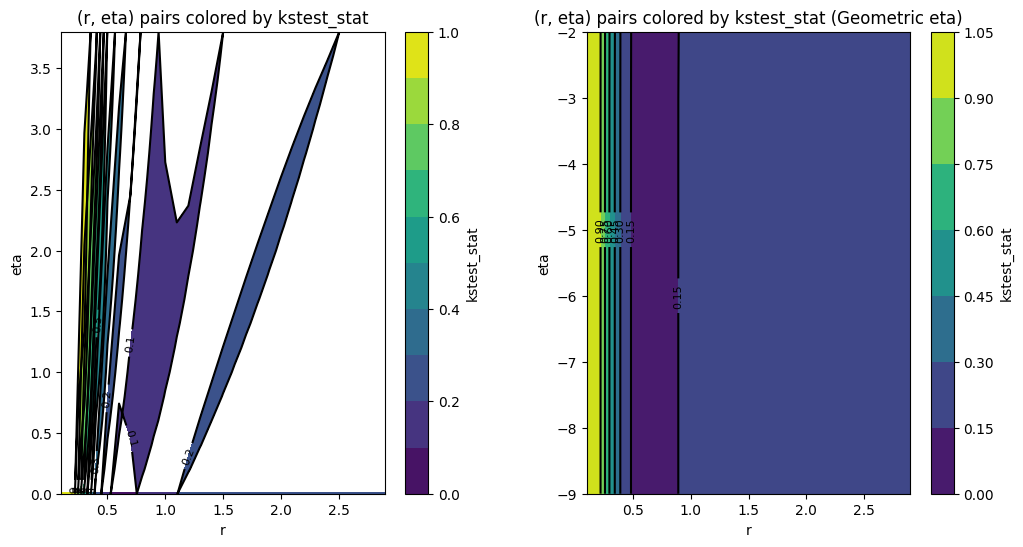

In [ ]:
create_contour_plot(df, 'kstest_stat')

In [363]:
df

,r,eta,cdf,kstest_stat,kstest_pval
0,0.1,0.000000,<scipy.interpolate._cubic.CubicSpline object a...,1.000000,0.0
1,0.1,0.200000,<scipy.interpolate._cubic.CubicSpline object a...,1.000000,0.0
2,0.1,0.400000,<scipy.interpolate._cubic.CubicSpline object a...,1.000000,0.0
3,0.1,0.600000,<scipy.interpolate._cubic.CubicSpline object a...,1.000000,0.0
4,0.1,0.800000,<scipy.interpolate._cubic.CubicSpline object a...,1.000000,0.0
...,...,...,...,...,...
807,2.9,0.000001,<scipy.interpolate._cubic.CubicSpline object a...,0.145346,0.0
808,2.9,0.000010,<scipy.interpolate._cubic.CubicSpline object a...,0.145345,0.0
809,2.9,0.000100,<scipy.interpolate._cubic.CubicSpline object a...,0.145341,0.0
810,2.9,0.001000,<scipy.interpolate._cubic.CubicSpline object a...,0.145294,0.0


<Axes: xlabel='r', ylabel='eta'>

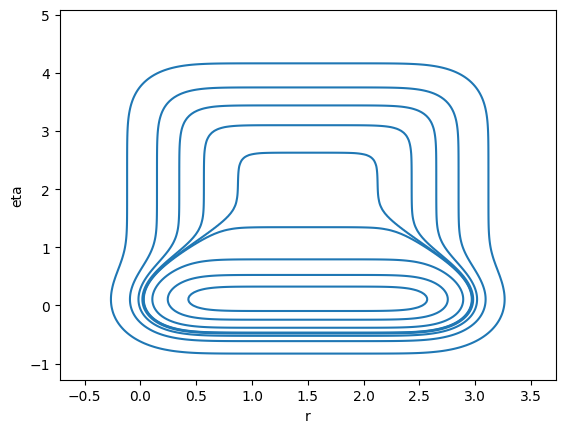

In [370]:
sns.kdeplot(df[['r', 'eta']], x = 'r', y = 'eta')

In [ ]:
with open('pickles/all_dist_df_full.pickle', 'rb') as handle:
    all_dist_df = pickle.load(handle)
print(all_dist_df.shape)
all_dist_df.head()

(21280, 9)


,base_r,base_eta,r,eta,distance,10,100,1000,10000
0,0.1,0,0.1,0,0.0,1.0,1.0,1.0,1.0
1,0.1,0.8,0.1,0,0.0,1.0,1.0,1.0,1.0
2,0.1,1.6,0.1,0,0.0,1.0,1.0,1.0,1.0
3,0.1,2.4,0.1,0,0.0,1.0,1.0,1.0,1.0
4,0.1,3.2,0.1,0,0.0,1.0,1.0,1.0,1.0


In [ ]:
def generate_heatmap_tile(df, metric_func=None, metric_col='metric', r_range=None, eta_range=None):
    """
    Generate a tile of heatmaps for the given metric function or metric column, and ranges of r and eta values.
    
    Args:
        df (pandas.DataFrame): The input dataframe containing columns 'base_r', 'base_eta', 'r', 'eta', and optionally the metric column.
        metric_func (callable, optional): The metric function that takes 'base_r', 'base_eta', 'r', 'eta' as arguments and returns a scalar value.
                                          If the metric column already exists in the dataframe, this argument can be omitted.
        metric_col (str, optional): The name of the column containing the metric values. Default is 'metric'.
        r_range (list or np.ndarray, optional): The range of r values to consider. If None, all unique r values in the dataframe will be used.
        eta_range (list or np.ndarray, optional): The range of eta values to consider. If None, all unique eta values in the dataframe will be used.
        
    Returns:
        matplotlib.figure.Figure: The figure object containing the tile of heatmaps.
    """
    # Check if the metric column exists in the dataframe
    if metric_col not in df.columns:
        # If the metric column doesn't exist, apply the metric function to the dataframe
        if metric_func is None:
            raise ValueError("Either the metric column or the metric function must be provided.")
        df[metric_col] = df.apply(lambda row: metric_func(row['base_r'], row['base_eta'], row['r'], row['eta']), axis=1)
    
    # If r_range or eta_range are not provided, use all unique values in the dataframe
    if r_range is None:
        r_range = sorted(df['r'].unique())
    if eta_range is None:
        eta_range = sorted(df['eta'].unique())
    
    # Sort the r and eta ranges
    base_r_values = sorted(set(df['base_r'].unique()))
    base_eta_values = sorted(set(df['base_eta'].unique()))
    
    # Create a figure with subplots
    fig, axs = plt.subplots(len(base_eta_values), len(base_r_values), figsize=(5*len(base_eta_values), 5*len(base_r_values)))
    
    # Iterate over the subplots and create heatmaps
    for i, base_eta in enumerate(base_eta_values):
        for j, base_r in enumerate(base_r_values):
            ax = axs[i, j]
            
            # Filter the dataframe based on base_r and base_eta
            filtered_df = df.loc[(df['base_r'] == base_r) & (df['base_eta'] == base_eta)]
            
            # Get the three closest values of r and eta for the filtered dataframe
            r_values = filtered_df['r'].unique()[:3]
            eta_values = filtered_df['eta'].unique()[:3]
            
            # Create the heatmap data
            heatmap_data = filtered_df.loc[filtered_df['r'].isin(r_values) & filtered_df['eta'].isin(eta_values)]
            heatmap_data = heatmap_data.pivot_table(index='eta', columns='r', values=metric_col)
            heatmap_data = heatmap_data.reindex(index=eta_values, columns=r_values, fill_value=np.nan)
            
            # Check if the heatmap data is empty
            if heatmap_data.empty:
                ax.set_visible(False)
                continue
            
            # Plot the heatmap
            sns.heatmap(heatmap_data.astype('float'), annot=True, annot_kws={'fontsize': 8}, cmap='viridis', ax=ax, alpha=0.4)
            ax.set_title(f'Base: r={base_r}, eta={base_eta}', fontsize=12)
            ax.set_xlabel('r', fontsize=10)
            ax.set_ylabel('eta', fontsize=10)
            
    # Add a set of axes outside the tiles
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("r", fontsize=14)
    plt.ylabel("eta", fontsize=14)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    return fig

In [23]:
import numpy as np

def kl_divergence(p, q, support):
    """
    Calculates the Kullback-Leibler (KL) divergence between two numerically approximated
    probability density functions (PDFs) p and q.

    Args:
        p (numpy.ndarray): The first PDF approximation.
        q (numpy.ndarray): The second PDF approximation.
        support (numpy.ndarray): The support values (e.g., x-axis values) for the PDFs.

    Returns:
        float: The KL divergence between p and q.
    """
    assert len(p) == len(q) == len(support), "PDFs and support must have the same length"

    # Compute the KL divergence
    kl_div = 0
    for i in range(len(p)):
        if p[i] > 0 and q[i] > 0:
            kl_div += p[i] * np.log(p[i] / q[i])

    # Approximate the KL divergence by multiplying with the step size
    step_size = support[1] - support[0]
    kl_div *= step_size

    return kl_div

In [26]:
xs, p1 = compute_prior_pdf(1, 0.8, 1000)
xs, p2 = compute_prior_pdf(1, 0.6, 1000)


In [27]:
kl_divergence(p1/np.sum(p1), p2/np.sum(p2), xs)

0.012467513568861225

In [ ]:
df = df5
metric = 'kstest_stat'
num_batch = 1000
shuffled_indices = np.random.permutation(df.shape[0])

def find_best_metric(df, metric):
    return df.set_index('')

In [ ]:
def create_layer_arr(data_dict, layer, all_cdfs, all_cdfs_df, only_diag = False):
    layer = rename_cols(data_dict[layer])
    if only_diag:
        ornt = ['D']
    else:
        ornt = ['H', 'V']
    x = np.array([np.concatenate(layer[layer["Orientation"] == direction]["Flattened Data"].values.flatten()) for direction in ornt]).flatten()
    obs_x = np.sort(x)
    return obs_x

def make_layer_df(data_dict, layer, all_cdfs, all_cdfs_df, only_diag = False):
    obs_x = create_layer_arr(data_dict, layer, all_cdfs, all_cdfs_df, only_diag = False)
    print(f"Number of samples: {obs_x.shape[0]}")
    df = all_cdfs_df.copy()
    kstest_stat_pval = all_cdfs_df.apply(lambda row : kstest_custom(obs_x, all_cdfs[(row.iloc[1], row.iloc[2])]), axis = 1)
    df['kstest_stat'] = kstest_stat_pval.str[0]
    df['kstest_pval'] = kstest_stat_pval.str[1]
    return df, obs_x

Number of samples: 51328


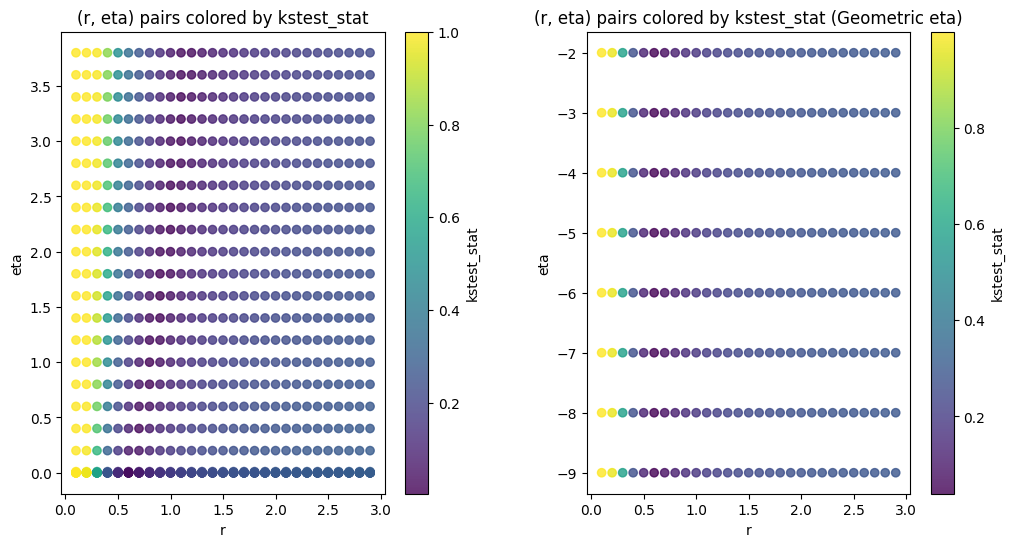

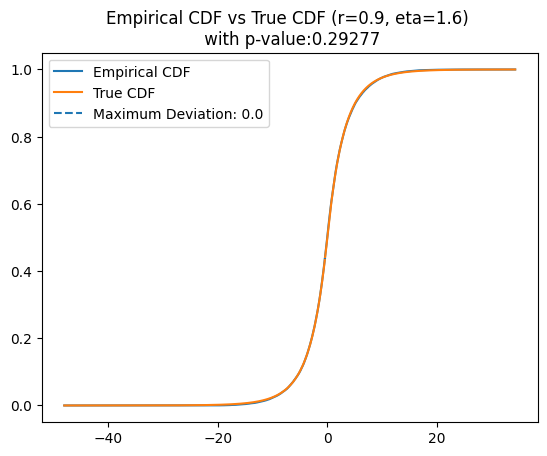

In [ ]:
xs = np.linspace(-100, 100, 10000)
df5, obs_x5 = make_layer_df(data_dict, 5, all_cdfs, all_cdfs_df)
create_scatter_plots(df5, 'kstest_stat')
distance, location = visualize_cdfs(obs_x, 0.9, 1.6, all_cdfs)

Number of samples: 12832


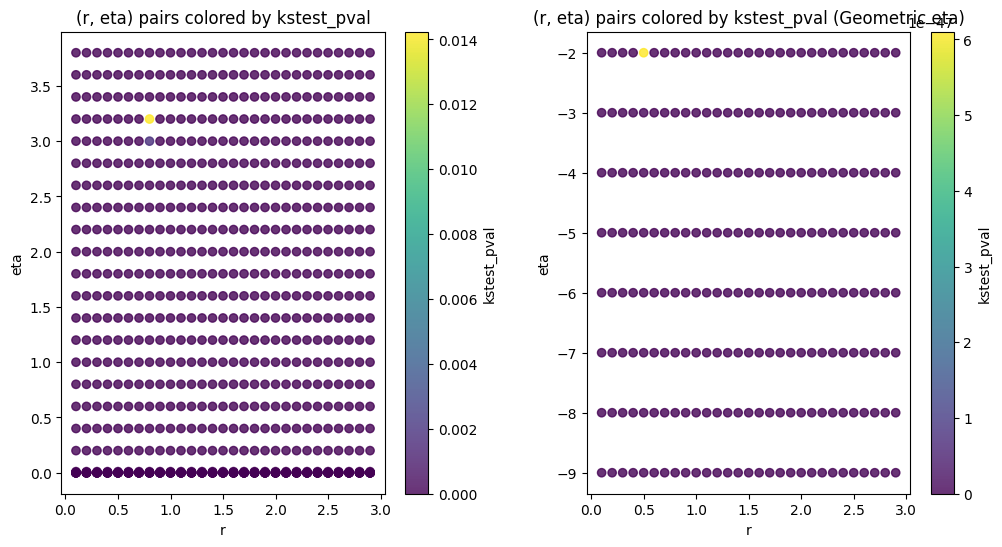

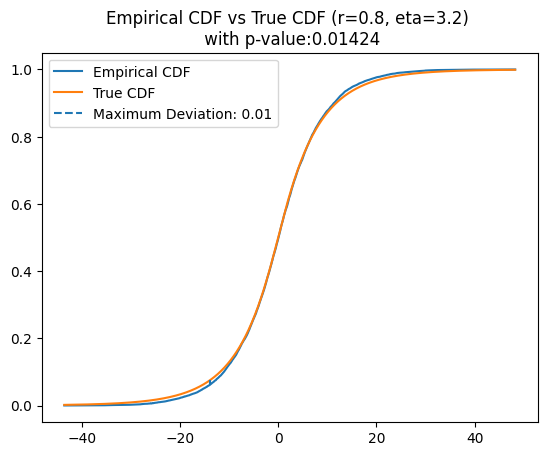

In [ ]:
xs = np.linspace(-100, 100, 10000)
df4, obs_x = make_layer_df(data_dict, 4, all_cdfs, all_cdfs_df)
create_scatter_plots(df4, 'kstest_pval')
distance, location = visualize_cdfs(obs_x, 0.8, 3.2, all_cdfs)

Number of samples: 205312


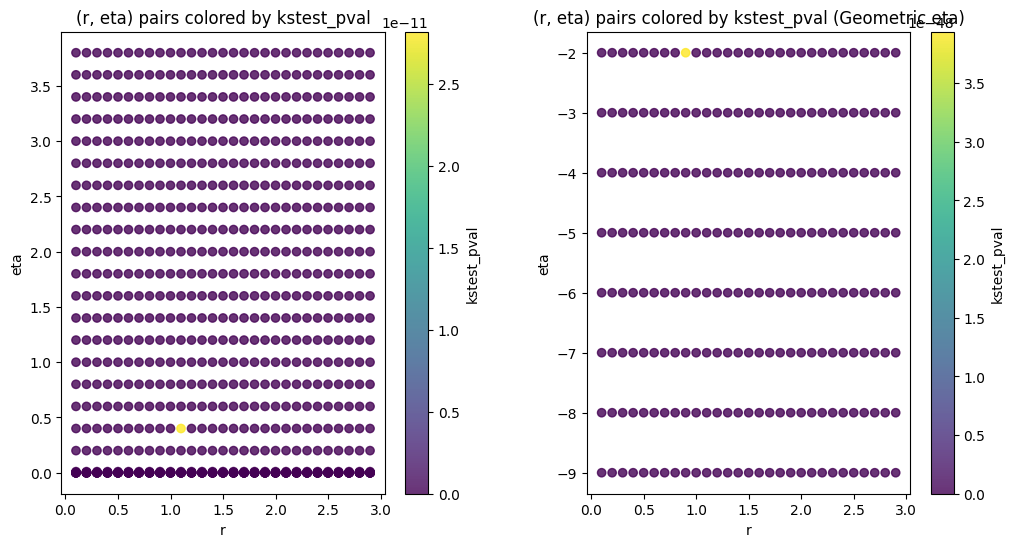

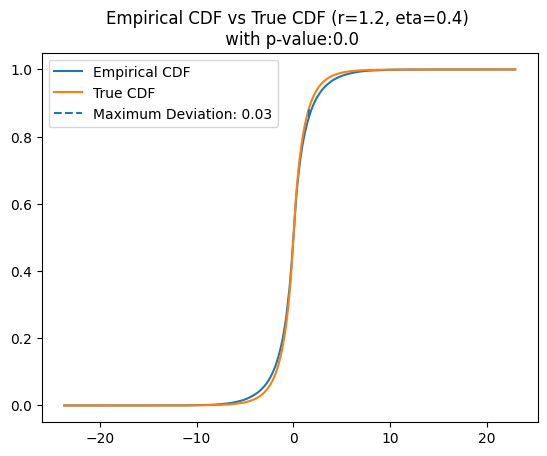

In [ ]:
xs = np.linspace(-100, 100, 10000)
df6, obs_x6 = make_layer_df(data_dict, 6, all_cdfs, all_cdfs_df)
create_scatter_plots(df6, 'kstest_pval')
distance, location = visualize_cdfs(obs_x6, 1.2, 0.4, all_cdfs)

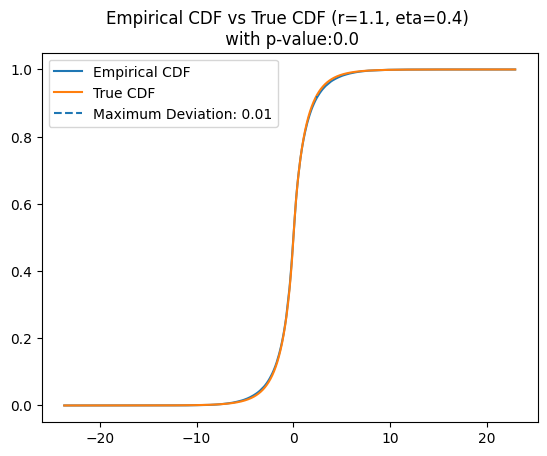

In [ ]:
distance, location = visualize_cdfs(obs_x6, 1.1, 0.4, all_cdfs)

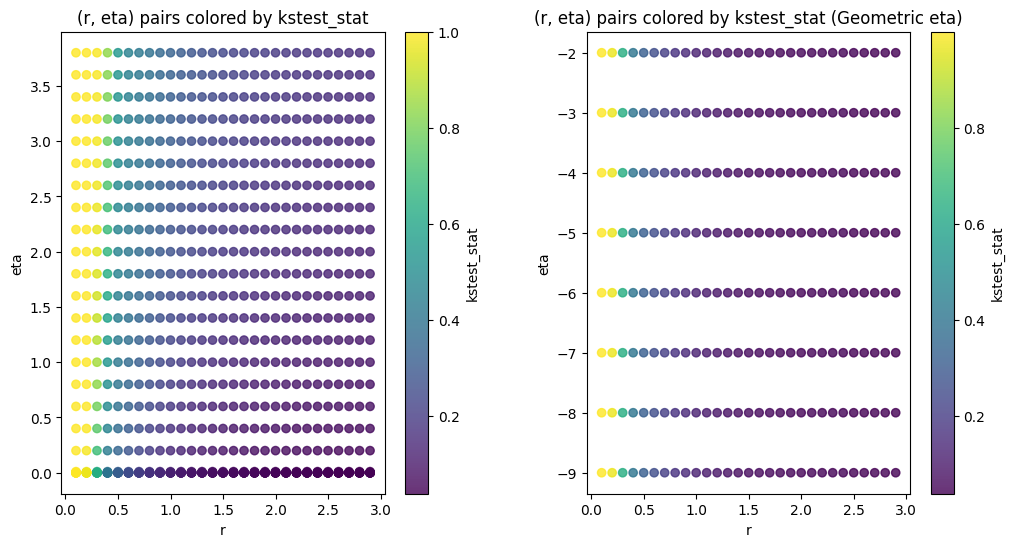

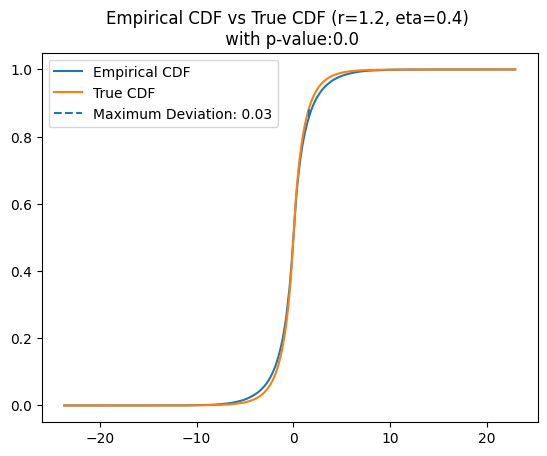

In [ ]:
create_scatter_plots(df7, 'kstest_stat')
distance, location = visualize_cdfs(obs_x6, 1.2, 0.4, all_cdfs)